<a href="https://colab.research.google.com/github/jetafese/btor2mlir/blob/ebpf/utils/ebpf/results/ebpf_results.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#eBPF Experiment Results


## Setup & Utilities

In [73]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

# Do not limit number of rows displayed
pd.set_option('display.max_rows', None)

In [74]:
TIMEOUTMAX = 20
MEMOUTMAX = 300000

def clean_csv(in_file, ref=False):
  df = pd.read_csv(in_file, dtype={'Result': 'string'})
  # drop rows that don't belong
  df = df[df["File"].str.contains("/cilium") == True]
  # assert (df.count()['File'] == 369)
  # get program name, ignore full path
  df[['path', 'program']] = df['File'].str.split(pat = '/cilium', expand = True)
  df = df.drop(columns=['path', 'File'])
  # distinguish between reference results and current results
  if ref:
    df = df.rename(columns = {'Result': 'prevail'})
    df = df.rename(columns = {'Cpu': 'prevail_t'})
    df = df.rename(columns = {'Mem': 'prevail_m'})
    df = df[['program', 'prevail', 'prevail_t', 'prevail_m']]
    # handle NAs
    df['prevail'] = df['prevail'].fillna("error")
    df['prevail_t'] = df['prevail_t'].fillna(TIMEOUTMAX)
    df['prevail_m'] = df['prevail_m'].fillna(MEMOUTMAX)
  else:
    df = df.rename(columns = {'Result': 'result'})
    # extract seahorn time
    df[['title', 'sea_time']] = df['seahorn_time'].str.split(pat = 'seahorn_total', expand = True)
    df = df.drop(columns=['title', 'seahorn_time'])
    # extract total time
    df[['time', 'mem_total']] = df['total'].str.split(pat = 'user', expand = True)
    df = df.drop(columns=['total'])
    # extract total memory
    df[['extra_1', 'mem_s']] = df['mem_total'].str.split(pat = '0avgdata', expand = True)
    df[['mem', 'extra_2']] = df['mem_s'].str.split(pat = 'maxresident', expand = True)
    df = df.drop(columns=['extra_1', 'mem_s', 'extra_2'])
    df = df[['program', 'result', 'trivial', 'sea_time', 'time', 'mem']]
    # handle NAs
    df['trivial'] = df['trivial'].fillna(0)
    df.loc[df['result'].str.contains('error'), 'mem'] = MEMOUTMAX
    df.loc[df['result'].str.contains('error'), 'time'] = TIMEOUTMAX
  return df

## Collect CSVs

In [114]:
#include csv for reference, current results
CURRENT = "/home/jetafese/btor2mlir/utils/ebpf/results/prevail_1029241329.csv"
REFERENCE = "/home/jetafese/btor2mlir/utils/ebpf/results/prevail_1029241118.csv"

current_results = clean_csv(CURRENT)
ref_results = clean_csv(REFERENCE, ref=True)
# current_results
# ref_results

## Interesting points

In [101]:
trivialForSeahorn = pd.merge(current_results, ref_results, how='inner', on='program')
trivialForSeahorn[trivialForSeahorn['trivial'] == 1.0]

,program,result,trivial,sea_time,time,mem,prevail,prevail_t,prevail_m


## Checking Disparities

### Soundness checks

In [115]:
testDF = pd.merge(current_results, ref_results, how='inner', on='program')
cilium = testDF[testDF['program'].str.startswith("/cilium/")]
betterThanPrevail = cilium[cilium['result'].str.startswith("1") & cilium['prevail'].str.startswith("0")]
worseThanPrevail = cilium[cilium['result'].str.startswith("0") & cilium['prevail'].str.startswith("1")]
betterThanPrevail
# worseThanPrevail

,program,result,trivial,sea_time,time,mem,prevail,prevail_t,prevail_m


In [116]:
mergedDF = pd.merge(current_results, ref_results, how='inner', on='program')
eqs = mergedDF['result'] == mergedDF['prevail']
diff = mergedDF['result'] != mergedDF['prevail']
print('ebpf2mlir agrees with prevail on: ', eqs.sum(), ', and differs on: ', diff.sum(), ' programs')

ebpf2mlir agrees with prevail on:  68 , and differs on:  63  programs


In [117]:
# resultAndNOTPrevail = mergedDF.query('result > prevail')
resultAndNOTPrevail = mergedDF[mergedDF['result'].str.startswith("1") & mergedDF['prevail'].str.startswith("0")]
print('total cases where result == 1 and prevail == 0...', resultAndNOTPrevail.count()['program'])
resultAndNOTPrevail.sort_values('prevail_t')

total cases where result == 1 and prevail == 0... 16


,program,result,trivial,sea_time,time,mem,prevail,prevail_t,prevail_m
88,/bpf/bpf_overlay.o:tc:cil_to_overlay,1,0.0,0.11,1.22,103572,0,0.008192,6312.0
124,/bpf/bpf_xdp.o:2/36:tail_nodeport_nat_ingress_...,1,0.0,3.00,12.39,155076,0,0.373956,28260.0
23,/bpf/bpf_host.o:2/22:tail_handle_ipv4_from_host,1,0.0,0.74,3.83,167384,0,0.590518,24288.0
96,/bpf/bpf_sock.o:cgroup/recvmsg6:cil_sock6_recvmsg,1,0.0,0.51,3.56,155304,0,0.602602,20268.0
53,/bpf/bpf_lxc.o:2/29:tail_ipv4_ct_egress,1,0.0,1.24,5.11,186872,0,0.872101,27284.0
123,/bpf/bpf_xdp.o:2/17:tail_nodeport_rev_dnat_ing...,1,0.0,1.61,6.64,180768,0,1.255430,52488.0
116,/bpf/bpf_xdp.o:2/21:tail_nodeport_ipv6_dsr,1,0.0,0.74,4.47,124936,0,1.306600,37992.0
125,/bpf/bpf_xdp.o:2/15:tail_nodeport_nat_egress_ipv4,1,0.0,1.08,8.77,168036,0,5.403230,268460.0
111,/bpf/bpf_wireguard.o:2/15:tail_nodeport_nat_eg...,1,0.0,1.58,9.17,245496,0,7.684850,205844.0
81,/bpf/bpf_overlay.o:2/15:tail_nodeport_nat_egre...,1,0.0,1.46,8.67,177336,0,7.825140,275264.0


In [118]:
prevailAndNotResult = mergedDF[mergedDF['result'].str.startswith("0") & mergedDF['prevail'].str.startswith("1")]
print('total cases where result == 0 and prevail == 1...', prevailAndNotResult.count()['program'])
prevailAndNotResult.sort_values('prevail_t')

total cases where result == 0 and prevail == 1... 27


,program,result,trivial,sea_time,time,mem,prevail,prevail_t,prevail_m
87,/bpf/bpf_overlay.o:tc:cil_from_overlay,0,0.0,0.25,1.30,101704,1,0.033914,7380.0
106,/bpf/bpf_wireguard.o:2/39:tail_handle_snat_fwd...,0,0.0,0.17,1.24,97328,1,0.065021,9356.0
41,/bpf/bpf_lxc.o:2/39:tail_handle_snat_fwd_ipv6,0,0.0,0.16,1.24,97640,1,0.065056,9584.0
3,/bpf/bpf_host.o:2/33:tail_srv6_encap,0,0.0,0.21,1.37,98560,1,0.102056,8688.0
35,/bpf/bpf_lxc.o:2/33:tail_srv6_encap,0,0.0,0.22,1.40,98688,1,0.102317,8468.0
100,/bpf/bpf_wireguard.o:2/33:tail_srv6_encap,0,0.0,0.21,1.39,98744,1,0.103323,8728.0
130,/bpf/bpf_xdp.o:xdp:cil_xdp_entry,0,0.0,0.33,2.17,99900,1,0.120070,9916.0
77,/bpf/bpf_overlay.o:2/24:tail_handle_nat_fwd_ipv6,0,0.0,0.64,3.39,100928,1,0.364191,18936.0
107,/bpf/bpf_wireguard.o:2/24:tail_handle_nat_fwd_...,0,0.0,0.63,3.36,101040,1,0.365266,19116.0
19,/bpf/bpf_host.o:2/23:tail_handle_ipv6_from_host,0,0.0,0.68,4.01,101516,1,0.437017,25120.0


In [119]:
prevailAndErrorResult = mergedDF[mergedDF['result'].str.startswith("error") & mergedDF['prevail'].str.startswith("1")]
print('total cases where result == error and prevail == 1...', prevailAndErrorResult.count()['program'])
# prevailAndErrorResult

total cases where result == error and prevail == 1... 3


In [120]:
NotPrevailAndErrorResult = mergedDF[mergedDF['result'].str.startswith("error") & mergedDF['prevail'].str.startswith("0")]
print('total cases where result == error and prevail == 0...', NotPrevailAndErrorResult.count()['program'])
# NotPrevailAndErrorResult

total cases where result == error and prevail == 0... 11


In [121]:
ErrorResultAndErrorPrevail = mergedDF[mergedDF['result'].str.startswith("error") & mergedDF['prevail'].str.contains("error")]
print('total cases where result == error and prevail == error...', ErrorResultAndErrorPrevail.count()['program'])
# ErrorResultAndErrorPrevail

total cases where result == error and prevail == error... 6


In [122]:
resultAndErrorPrevail = mergedDF[mergedDF['result'].str.startswith("1") & mergedDF['prevail'].str.contains("error")]
print('total cases where result == 1 and prevail == error...', resultAndErrorPrevail.count()['program'])
# resultAndErrorPrevail

total cases where result == 1 and prevail == error... 0


In [123]:
NotResultAndErrorPrevail = mergedDF[mergedDF['result'].str.startswith("0") & mergedDF['prevail'].str.contains("error")]
print('total cases where result == 0 and prevail == error...', NotResultAndErrorPrevail.count()['program'])
# NotResultAndErrorPrevail

total cases where result == 0 and prevail == error... 0


## Failing Pipelines


In [98]:
failures = pd.merge(current_results, ref_results, how='inner', on='program')
print('total number of failures: ', failures[failures['result'].str.contains("error")].count()['result'])
print('failures due to llvm casting: ', failures[failures['result'].str.contains("llvm dialect")].count()['result'])
print('failures due to translation code: ', failures[failures['result'].str.contains("translation")].count()['result'])
print('failures due to linking error: ', failures[failures['result'].str.contains("linking")].count()['result'])
print('failures due to seahorn timeout: ', failures[failures['result'].str.contains("timeout")].count()['result'])

total number of failures:  21
failures due to llvm casting:  16
failures due to translation code:  5
failures due to linking error:  0
failures due to seahorn timeout:  0


### llvm casting bug (dialect conversion)

In [87]:
castingBug = pd.merge(current_results, ref_results, how='inner', on='program')
castingBug[castingBug['result'].str.contains("llvm")]

,program,result,trivial,sea_time,time,mem,prevail,prevail_t,prevail_m
7,/bpf/bpf_host.o:2/37:tail_nodeport_nat_ingress...,error: to llvm dialect conversion failed,0.0,NaN,20,300000,0,0.344699,22016.0
17,/bpf/bpf_host.o:2/45:tail_handle_ipv6_cont_fro...,error: to llvm dialect conversion failed,0.0,NaN,20,300000,0,7.060950,34116.0
20,/bpf/bpf_host.o:2/10:tail_handle_ipv6_from_netdev,error: to llvm dialect conversion failed,0.0,NaN,20,300000,1,8.077880,119468.0
25,/bpf/bpf_host.o:tc:cil_from_netdev,error: to llvm dialect conversion failed,0.0,NaN,20,300000,1,0.347072,20132.0
26,/bpf/bpf_host.o:tc:cil_from_host,error: to llvm dialect conversion failed,0.0,NaN,20,300000,1,0.369388,14928.0
27,/bpf/bpf_host.o:tc:cil_to_netdev,error: to llvm dialect conversion failed,0.0,NaN,20,300000,0,8.183350,62564.0
28,/bpf/bpf_host.o:tc:cil_to_host,error: to llvm dialect conversion failed,0.0,NaN,20,300000,error,20.000000,300000.0
29,/bpf/bpf_host.o:tc:handle_lxc_traffic,error: to llvm dialect conversion failed,0.0,NaN,20,300000,0,17.221100,68404.0
39,/bpf/bpf_lxc.o:2/37:tail_nodeport_nat_ingress_...,error: to llvm dialect conversion failed,0.0,NaN,20,300000,0,1.157840,33924.0
61,/bpf/bpf_lxc.o:2/14:tail_ipv6_to_endpoint,error: to llvm dialect conversion failed,0.0,NaN,20,300000,1,2.662070,19216.0


### many exits in program (translation)

In [88]:
translationBug = pd.merge(current_results, ref_results, how='inner', on='program')
translationBug[translationBug['result'].str.contains("translation")]

,program,result,trivial,sea_time,time,mem,prevail,prevail_t,prevail_m
49,/bpf/bpf_lxc.o:2/26:tail_handle_ipv6_cont,error: translation failed,0.0,NaN,20,300000,error,20.0,300000.0
52,/bpf/bpf_lxc.o:2/25:tail_handle_ipv4_cont,error: translation failed,0.0,NaN,20,300000,error,20.0,300000.0
60,/bpf/bpf_lxc.o:2/12:tail_ipv6_policy,error: translation failed,0.0,NaN,20,300000,error,20.0,300000.0
64,/bpf/bpf_lxc.o:2/11:tail_ipv4_policy,error: translation failed,0.0,NaN,20,300000,error,20.0,300000.0
70,/bpf/bpf_overlay.o:2/49:tail_mcast_ep_delivery,error: translation failed,0.0,NaN,20,300000,error,20.0,300000.0


### seahorn timeout 

In [89]:
timeouts = pd.merge(current_results, ref_results, how='inner', on='program')
timeouts[timeouts['result'].str.contains("timeout")]

,program,result,trivial,sea_time,time,mem,prevail,prevail_t,prevail_m


## Graphs

In [90]:
import numpy as np

def compare_values(columnA, columnB, df_A, df_B):
    df_A[columnA] = pd.to_numeric(df_A[columnA], errors='coerce')
    df_B[columnB] = pd.to_numeric(df_B[columnB], errors='coerce')
    vals_A = df_A[['program', columnA]]
    vals_B = df_B[['program', columnB]]
    merged = vals_A.merge(vals_B, how='inner', on='program')
    return merged

def scatter_values(columnA, columnB, df_A, df_B, titleA, titleB, maxVal):
    vals = compare_values(columnA, columnB, df_A, df_B)
    xlabel = columnA
    ylabel = columnB

    xs = vals[xlabel]
    ys = vals[ylabel]

    min_val = min(0, min(xs), min(ys))
    max_val = max(max(xs), max(ys), maxVal+5)
    plt.xlim(min_val, max_val)
    plt.ylim(min_val, max_val)

    plt.scatter(xs, ys)
    plt.gca().set_aspect('equal', adjustable='box')
    plt.xlabel(titleA)
    plt.ylabel(titleB)

    mid_x = np.linspace(min_val, max_val, 2)
    mid_y = mid_x
    plt.plot(mid_x, mid_y, 'r-')
    plt.title(f'{titleA} vs {titleB}')

    plt.rcParams['figure.dpi'] = 160
    plt.draw()

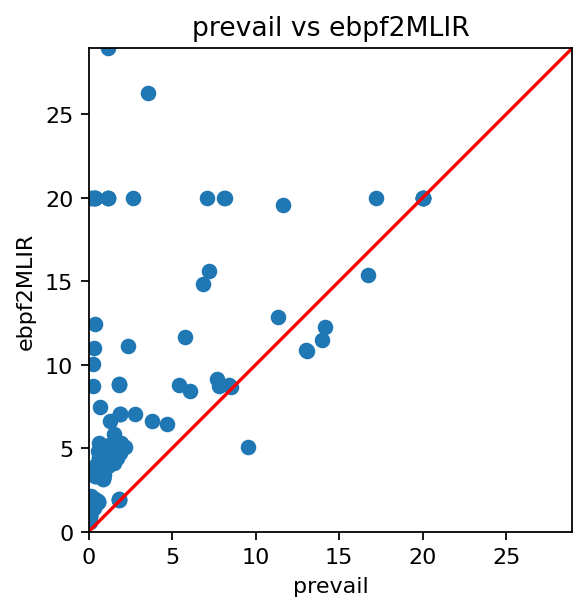

In [91]:
scatter_values('prevail_t', 'time', ref_results, current_results, "prevail", "ebpf2MLIR", TIMEOUTMAX)

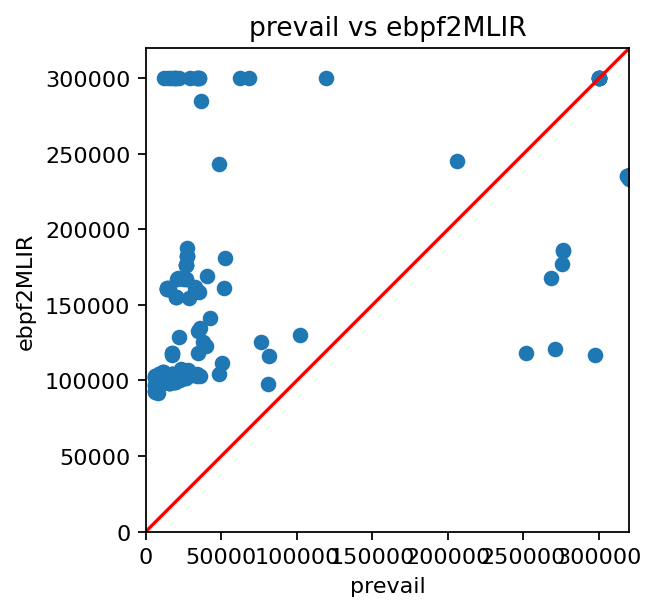

In [92]:
scatter_values('prevail_m', 'mem', ref_results, current_results, "prevail", "ebpf2MLIR", MEMOUTMAX)